
# Dog breed classification 

CNN based on [lesson 2](http://course.fast.ai/lessons/lesson2.html) of the deep learning fast.ai course, with data from the Kaggle Competition [dog-breed-identification](https://www.kaggle.com/c/dog-breed-identification).

This excercise follows the lesson's steps to train a world class classification model:

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# See http://forums.fast.ai/t/torch-cuda-is-available-returns-false/16721/8
# And https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [6]:
# ! dir ..\..\..\Github\data\dog-breed-identification

In [7]:
PATH = "..\\..\\..\\Github\\data\\dog-breed-identification\\"
PATH = "../data/dog-breed-identification/"

## Initial Exploration

In [8]:
# os.listdir(PATH)
# ! ls {PATH}
! dir {PATH}

labels.csv	   sample_submission.csv      test.zip	train.zip
labels.csv.zip	   sample_submission.csv.zip  tmp
sample_labels.csv  test			      train


In [9]:
os.listdir(f'{PATH}train')[:5]

['3f06362327d11ca13c01a19182911927.jpg',
 '28324516db1ad19c3b33c1b6ad397774.jpg',
 '62b930bc746b25a1a68518194c0ef059.jpg',
 '82cd7074fe9b46b58a0ef2b74457026b.jpg',
 '369f1231c318aafcdcb56a0cdd63b5f0.jpg']

In [10]:
labels_df = pd.read_csv(PATH + 'labels.csv')
print('There are', len(labels_df), 'training observations, and',
      len(os.listdir(f'{PATH}test')), 'test observations.')
labels_df.sample(5)

There are 10222 training observations, and 10357 test observations.


,id,breed
7395,b92385d243ab068cccd12337210af6b7,old_english_sheepdog
8745,db3cb1060eb49e6fbdbe08082b8626d1,gordon_setter
1168,1d2c069aa91e2818f1a45a7ea1892e9c,border_collie
9417,ec3445c0c4db2d219b2377cb0eb8f3dd,airedale
3862,5fc0c3dd9481cc47e02edb9bc776bf47,brabancon_griffon


In [11]:
labels_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


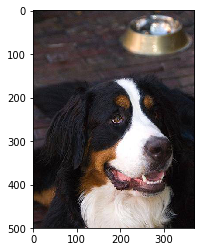

In [12]:
img = plt.imread(PATH + 'train/' + labels_df.sample(1)['id'].values[0] + '.jpg')
plt.imshow(img)

### Sample subset of images (for cpu only)

In [13]:
frac = 0.5
sample_labels_df = labels_df.sample(frac=frac).set_index('id')
sample_labels_df.to_csv(PATH + 'sample_labels.csv')

In [14]:
sample_labels_df.head()

,breed
id,
6aa14a87ed25a19e2afb72aa3c2651ff,briard
203581bbee6e5dc08c511d236aae6ec4,black-and-tan_coonhound
a13095bdd2938c8666addc680b84589a,newfoundland
369f1231c318aafcdcb56a0cdd63b5f0,appenzeller
b44ddd50615e6526250b84754798c47d,clumber


# Model

> If the original images do not correspond to this size, thei are center cropped. For computational GPU reasons, the cropped images must be squared."

In [15]:
# Image size to feed into the model.  
sz = 224

arch = resnext101_64  # resnet34  # Model architecture.
bs = 64  # Batch size


n = len(labels_df)  # len(list(open(PATH + 'labels.csv'))) - 1
val_idxs = get_cv_idxs(n, val_pct=0.2)

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'labels.csv',
                                    test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [17]:
fn = PATH + data.trn_ds.fnames[10]; fn

'../data/dog-breed-identification/train/007b5a16db9d9ff9d7ad39982703e429.jpg'

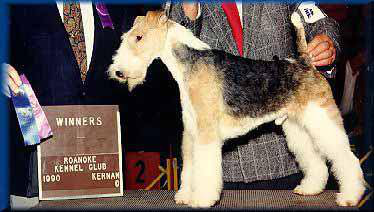

In [18]:
img = PIL.Image.open(fn); img

In [19]:
img.size

(374, 212)

In [20]:
sizes_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*sizes_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

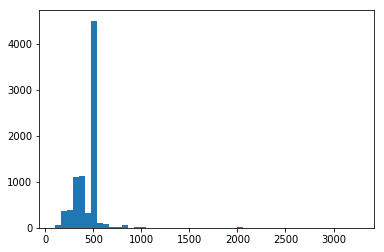

In [21]:
plt.hist(row_sz, bins = 50);  # semi-colon for not printing the bins of the histogram.

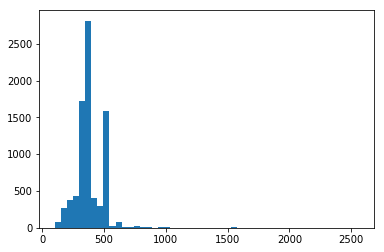

In [22]:
plt.hist(col_sz, bins = 50);

## 1. Precompute

(Enable data augmentation, and precompute=True)

The following function helps iterate faster with the model.  It receives the image's size (`sz`) and the batch size (`bs`).

1. Start with small sizes (eg. 64) for fast computing at the beginning.  Then increase the size.
1. If one runs out of memory, first **restart the kernel**, then decrease the batch size.


In [27]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'labels.csv',
                                        test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [36]:
sz = 224
bs = 64
data = get_data(sz, bs)

In [37]:
# See http://forums.fast.ai/t/dog-breed-challenge-precompute-error/10988/8
# If No such file... error: ~/data/dog-breed-identification$ rm -r tmp
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [05:45<00:00,  2.13s/it]


In [30]:
# learn.save('pretrained_128')
learn.save('pretrained_224')

In [31]:
# learn.load('pretrained_128')
learn.load('pretrained_224')

In [32]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                   
    0      1.462207   0.832935   0.784736  
    1      0.873883   0.744843   0.781311                    
    2      0.690479   0.710663   0.792074                    
    3      0.599436   0.70272    0.792074                    
    4      0.479676   0.703564   0.799413                    



[array([0.70356]), 0.7994129162012015]

> The difference between trn_loss and val_loss indicates **overfitting**.  Maybe with dropout (`ps` parameter in `ConvLearner.pretrained`) or another form of regularization.

In [ ]:
lrf = learn.lr_find()
# learn.sched.plot_lr()
learn.sched.plot()

 23%|██▎       | 29/128 [01:02<03:34,  2.17s/it, loss=1.15]

## 2. Augment 

In [42]:
from sklearn import metrics

In [45]:
data = get_data(sz, bs)

In [53]:
# ps: dropout parameter
learn = ConvLearner.pretrained(arch, data, precompute=True, ps = 0.75)

In [54]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.606468   0.858011   0.860568  
    1      1.339476   0.45891    0.887965                   



[array([0.45891]), 0.8879647746011469]

In [55]:
learn.precompute = False

In [50]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.485359   0.28829    0.916341  
    1      0.425597   0.274352   0.915362                    
    2      0.397701   0.264509   0.913405                    
    3      0.365487   0.262731   0.911937                    
    4      0.335365   0.251201   0.917319                    



[array([0.2512]), 0.9173189825041187]

In [51]:
learn.save('pre_224')

In [52]:
learn.load('pre_224')

## Increase size 

In [ ]:
learn.set_data(get_data(299, bs))
learn.freeze()